In [1]:
import torch
import torch.nn as nn
import torchvision, os
from torchvision import transforms, utils, datasets
from torch.utils.data import DataLoader, Dataset, sampler, SubsetRandomSampler, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler 
from PIL import Image
from sklearn.model_selection import train_test_split
import sys
import math
import numpy as np
import pandas as pd
import warnings
import random, h5py
warnings.filterwarnings('ignore')
plt.ion()

## Configuring GPU for training

In [2]:
# checking if cuda is available
train_on_gpu = torch.cuda.is_available()
torch.cuda.set_device(1)
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on Tesla T4 Device {}'.format(str(torch.cuda.current_device())))

CUDA is available!  Training on Tesla T4 Device 1


## Importing data from H5 files

In [3]:
# opening h5 files
ROOT_DIR = "/home/nikunjlad"
hf = h5py.File(os.path.join(ROOT_DIR,"data/cifar-10/cifar10.h5"), 'r')

In [4]:
hf.keys()   # datasets contained in h5 files

<KeysViewHDF5 ['X_test', 'X_train', 'y_test', 'y_train']>

In [5]:
x_train = np.array(hf.get("X_train"), dtype=np.float32)
y_train = np.array(hf.get("y_train"), dtype=np.int64)
x_test = np.array(hf.get("X_test"), dtype=np.float32)
y_test = np.array(hf.get("y_test"), dtype=np.int64)

## Data Preparation

In [6]:
class Dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [7]:
valid_size = 0.1
num_train = len(x_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
X_train_1 = x_train[train_idx,:,:,:]
y_train_1 = y_train[train_idx]
X_valid_1 = x_train[valid_idx, :, :, :]
y_valid_1 = y_train[valid_idx]
train_data =list(X_train_1.transpose(0, 3, 1, 2)) 
train_targets = list(y_train_1)
valid_data =list(X_valid_1.transpose(0, 3, 1, 2)) 
valid_targets = list(y_valid_1)
test_data = list(x_test.transpose(0, 3, 1, 2))
test_targets = list(y_test)

In [8]:
# transformations to apply on training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# transformations to apply on testing data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# creating training, validation and testing datasets, using the Dataset class implemented from torch.utils.data.Dataset
train_dataset = Dataset(train_data, train_targets, transform_train)
valid_dataset = Dataset(valid_data, valid_targets, transform = transform_test)
test_dataset = Dataset(test_data, test_targets, transform = transform_test)

# configuring dataloaders to loader datasets in batches
batch_size=128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# number of samples in training, validation and testing
train_data_size = len(train_dataset)
valid_data_size = len(valid_dataset)
test_data_size = len(test_dataset)

# number of batches of training, validation and testing data
num_train_data_batches = len(train_dataloader)
num_valid_data_batches = len(valid_dataloader)
num_test_data_batches = len(test_dataloader)

In [10]:
print("Number of training samples: ", train_data_size)
print("{} batches each having {} samples".format(str(num_train_data_batches), str(batch_size)))
print("Number of validation samples: ", valid_data_size)
print("{} batches each having {} samples".format(str(num_valid_data_batches), str(batch_size)))
print("Number of testing samples: ", test_data_size)
print("{} batches each having {} samples".format(str(num_test_data_batches), str(batch_size)))

Number of training samples:  45000
352 batches each having 128 samples
Number of validation samples:  5000
40 batches each having 128 samples
Number of testing samples:  10000
79 batches each having 128 samples


## Visualizing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch image tensor dimensions:  torch.Size([128, 3, 32, 32])
Batch label tensor dimensions:  torch.Size([128])


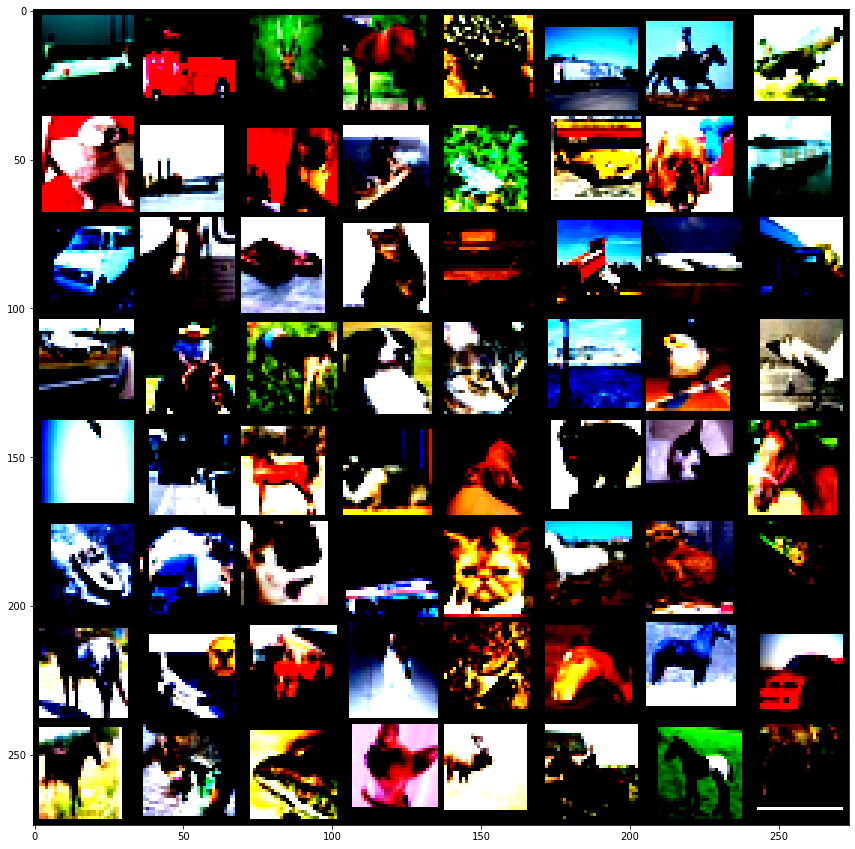

In [11]:
batch = next(iter(train_dataloader))
images, labels = batch

grid = torchvision.utils.make_grid(images[:64], nrow=8)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

for data, target in train_dataloader:
    print("Batch image tensor dimensions: ", data.shape)
    print("Batch label tensor dimensions: ", target.shape)
    break

## Architecting Neural Network Model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.norm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*6*6, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.norm2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(-1, 64*6*6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

net = Net()
print(net)
if train_on_gpu:
    net.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2304, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9, weight_decay=5e-4)

In [14]:
batch_size = 128
np_epochs = 150
valid_loss_min = np.Inf
f = 0
# lists to store epochs, training loss and validation loss values
epoch_list = []
train_loss_list = []
valid_loss_list = []

In [15]:
for epoch in range(np_epochs):
    if f < 7:
        train_loss = 0
        valid_loss = 0
        net.train()
        for data, labels in iter(train_dataloader):
            if train_on_gpu:
                data, labels = data.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)

        net.eval()
        for data, labels in iter(valid_dataloader):
            if train_on_gpu:
                data, labels = data.cuda(), labels.cuda()
                outputs = net(data)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()*data.size(0)

        train_loss = train_loss/len(train_dataloader.sampler)
        valid_loss = valid_loss/len(valid_dataloader.sampler)
        print('Epoch : {} \t Training loss : {:.4f} \t Validation loss : {:.4f}'.format(epoch, train_loss, valid_loss))
        epoch_list.append(epoch)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        if valid_loss < valid_loss_min:
            f = 0
            print('Valid loss decreased from : {:.4f} ----> {:.4f}'.format(valid_loss_min, valid_loss))
            torch.save(net.state_dict(), 'model_cifar3.pt')
            valid_loss_min = valid_loss
        else:
            f += 1

Epoch : 0 	 Training loss : 2.2428 	 Validation loss : 2.1196
Valid loss decreased from : inf ----> 2.1196
Epoch : 1 	 Training loss : 1.9966 	 Validation loss : 1.8579
Valid loss decreased from : 2.1196 ----> 1.8579
Epoch : 2 	 Training loss : 1.7304 	 Validation loss : 1.6033
Valid loss decreased from : 1.8579 ----> 1.6033
Epoch : 3 	 Training loss : 1.5945 	 Validation loss : 1.5000
Valid loss decreased from : 1.6033 ----> 1.5000
Epoch : 4 	 Training loss : 1.5187 	 Validation loss : 1.4212
Valid loss decreased from : 1.5000 ----> 1.4212
Epoch : 5 	 Training loss : 1.4593 	 Validation loss : 1.3480
Valid loss decreased from : 1.4212 ----> 1.3480
Epoch : 6 	 Training loss : 1.4058 	 Validation loss : 1.2954
Valid loss decreased from : 1.3480 ----> 1.2954
Epoch : 7 	 Training loss : 1.3673 	 Validation loss : 1.2532
Valid loss decreased from : 1.2954 ----> 1.2532
Epoch : 8 	 Training loss : 1.3201 	 Validation loss : 1.1991
Valid loss decreased from : 1.2532 ----> 1.1991
Epoch : 9 	 T

In [ ]:
plt.figure(figsize=(8,8))
x = epoch_list
plt.plot(x, train_loss_list)
plt.plot(x, valid_loss_list)
plt.legend(['train_loss', 'valid_loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("CIFAR-10 Loss Curves")
plt.xlim(0,50)
plt.show()

In [ ]:
net.load_state_dict(torch.load('model_cifar2.pt'))

In [ ]:
test_loss = 0.0     # making test loss is equal to 0
class_correct = list(0. for i in range(10))   # correct class list of 
class_total = list(0. for i in range(10))
j = 0
test_accuracy = 0

In [ ]:
classes = [
    '0 - airplane',
    '1 - automobile',
    '2 - bird',
    '3 - cat',
    '4 - deer',
    '5 - dog',
    '6 - frog',
    '7 - horse',
    '8 - ship',
    '9 - truck']

In [ ]:
net.eval()
# iterate over test data
for data, target in test_dataloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    if len(target) == batch_size:
        j = batch_size
    else:
        j = len(target)
        
    for i in range(j):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1   
        
# average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))
test_accuracy = (100. * np.sum(class_correct) / np.sum(class_total))

## Observations

Run1
1. Epochs = 150
2. batch size = 64
3. optimizer = SGD
4. alpha = 0.0005
5. training loss = 0.4946
6. validation loss = 0.5074
7. test loss = 0.506
8. test accuracy = 82%
9. model = model_cifar.pt
10. dropout = 0.5

Run2 
1. Epochs = 150
2. batch size = 64
3. optimizer = Adam
4. alpha = 0.0005
5. training loss = 0.5096   (stopped at 83rd epoch)
6. validation loss = 0.5366
7. test loss = 0.5123
8. test accuracy = 82%
9. model = model_cifar1.pt
10. dropout = 0.5

Run3
1. Epochs = 150
2. batch size = 128
3. optimizer = SGD
4. alpha = 0.0005
5. training loss = 0.5838   (stopped at 145th epoch)
6. validation loss = 0.5364
7. test loss = 0.5379
8. test accuracy = 81%
9. model = model_cifar2.pt
10. dropout = 0.5